# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [6]:
# Завантажую датасет
df = pd.read_csv('bikes_rent.csv')
print(df[:5])

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

[text odkazu](https://)Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

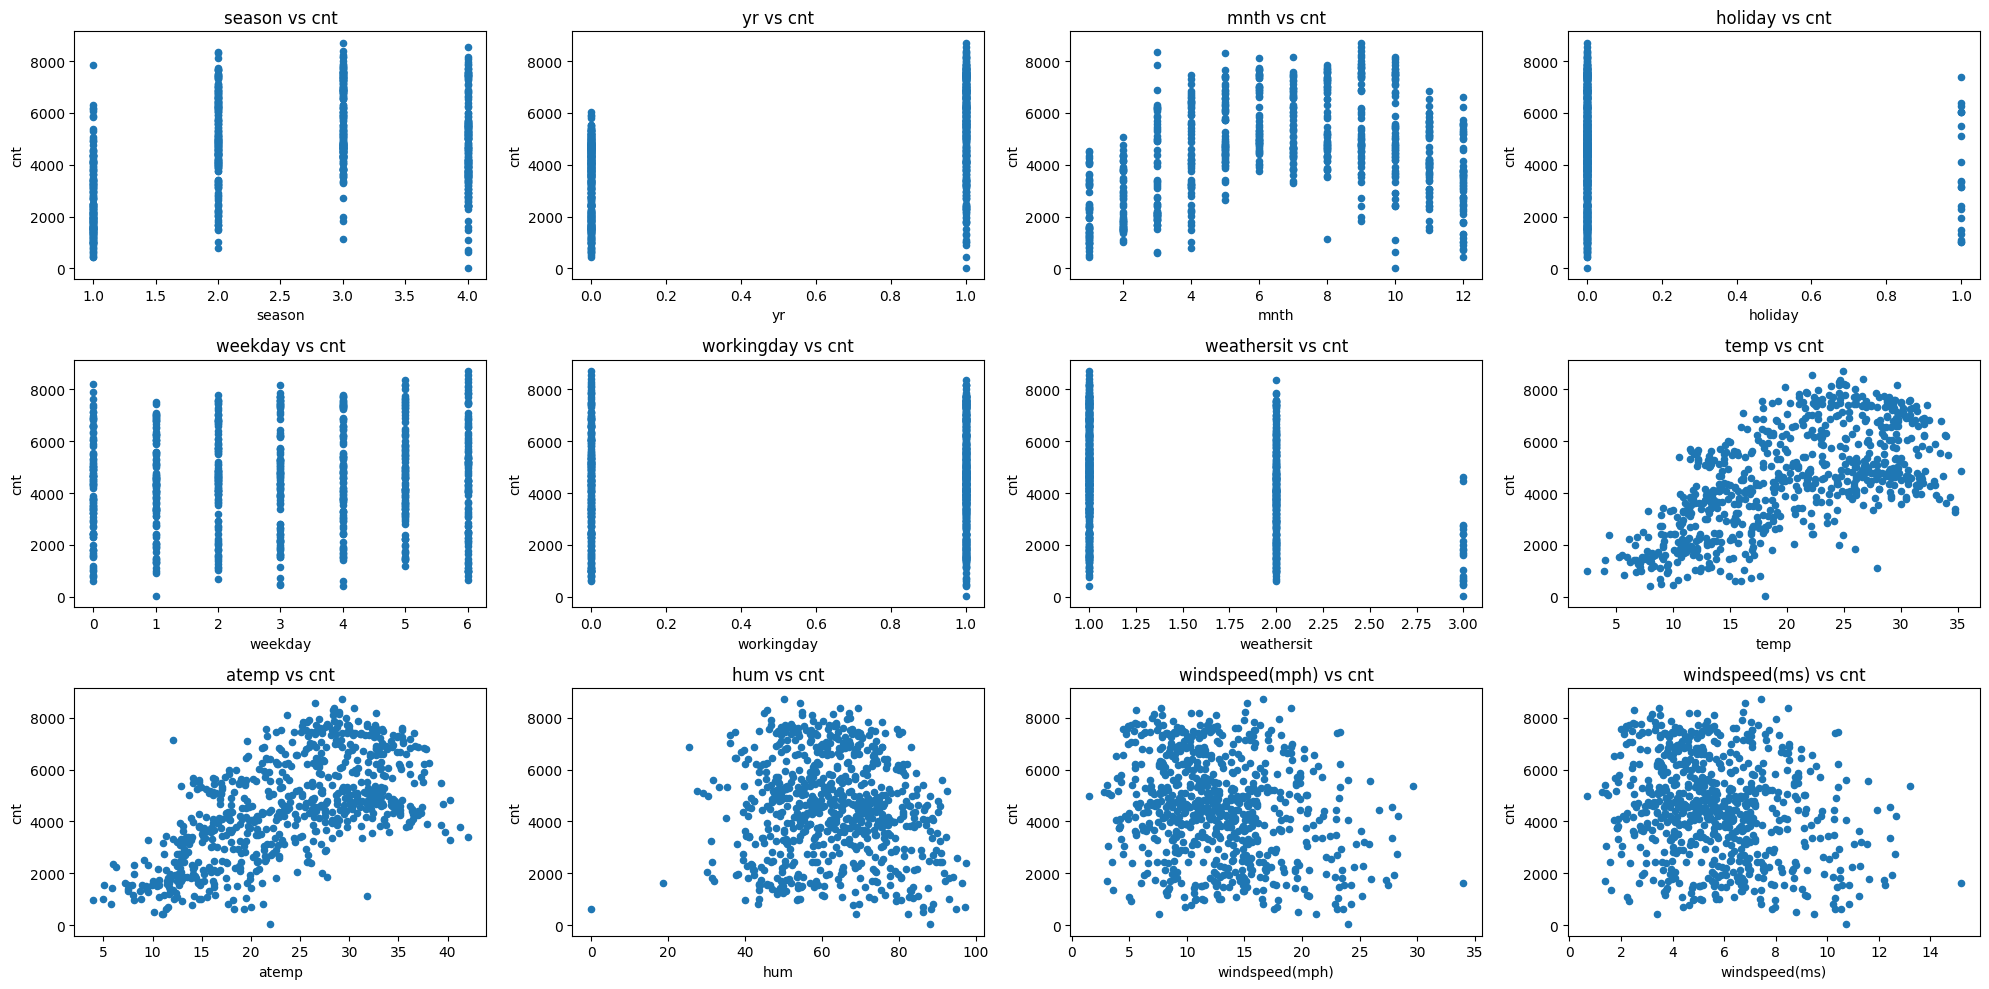

In [9]:
# Промальовуємо всі залежності одним кодом

plt.figure(figsize=(20, 10))
# Залежність ознак від 'cnt'
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
for i, feature in enumerate(features, 1):x
    plt.subplot(3, 4, i)
    df.plot(=feature, y='cnt', kind='scatter', ax=plt.gca())
    plt.title(f'{feature} vs cnt')

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
**Відповідь:** лінійний, найбільша кількість прокатів була в літні та осінні місяці
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.
**Відповідь:** Місяць, дні тижня, температрура

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [10]:
# Обчислення кореляцій
correlations = df.iloc[:, :-1].corrwith(df['cnt'])

# Виведення кореляцій
print(correlations)


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [13]:
# Вибірка потрібних ознак
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
selected_data = df[selected_features]

# Обчислення попарних кореляцій
correlations_paired = selected_data.corr()

# Виведення кореляцій
print(correlations_paired)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [14]:
# Обчислення середніх значень ознак
mean_values = df.mean()

# Виведення середніх значень
print(mean_values)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [15]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [16]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# Розділення ознак та цільової змінної
X = df.drop(columns=['cnt'])  # Ознаки, крім 'cnt'
y = df['cnt']  # Цільова змінна 'cnt'

# Навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X, y)

# Виведення ваг ознак
feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': model.coef_})
print(feature_weights)


           Feature        Weight
0           season  5.142757e+02
1               yr  2.043933e+03
2             mnth -4.096318e+01
3          holiday -5.193860e+02
4          weekday  6.849570e+01
5       workingday  1.212928e+02
6       weathersit -6.064543e+02
7             temp  4.899417e+01
8            atemp  7.191633e+01
9              hum -1.023064e+01
10  windspeed(mph)  2.400996e+12
11   windspeed(ms) -5.371028e+12


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [26]:
# Створення та навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X, y)

# Виведення ваг моделі
print("Weights of the linear regression model:")
for feature, weight in zip(X.columns, model.coef_):
    print(f"{feature : <15}: {weight.round(2)}")

Weights of the linear regression model:
season         : 514.28
yr             : 2043.93
mnth           : -40.96
holiday        : -519.39
weekday        : 68.5
workingday     : 121.29
weathersit     : -606.45
temp           : 48.99
atemp          : 71.92
hum            : -10.23
windspeed(mph) : 2400995993962.54
windspeed(ms)  : -5371028038579.01


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [ ]:
# Put your code here

season: 560.241616031
yr: 1019.46349407
mnth: -128.730627037
holiday: -86.1527813337
weekday: 137.347893905
workingday: 55.2123706414
weathersit: -332.369856962
temp: 376.36323621
atemp: 576.530793505
hum: -144.129155003
windspeed(mph): -197.139689402
windspeed(ms): -2.80498119457e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [ ]:
# Put your code here

season: 563.064572252
yr: 1018.94837879
mnth: -131.873320282
holiday: -86.7460979971
weekday: 138.005111179
workingday: 55.9031103751
weathersit: -332.349788499
temp: 386.457889192
atemp: 566.34704706
hum: -145.071327299
windspeed(mph): -99.2594410818
windspeed(ms): -99.2594411544


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для когоожн значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [29]:
from sklearn.linear_model import Lasso, Ridge
alphas = np.arange(1, 500, 50)

# Ініціалізація списків для зберігання ваг
coefs_lasso = []
coefs_ridge = []

# Навчання регресорів Lasso та Ridge для різних значень alpha
for alpha in alphas:
    # Навчання Lasso
  lasso = Lasso(alpha=alpha)
  lasso.fit(X, y)
  coefs_lasso.append(lasso.coef_)

    # Навчання Ridge
  ridge = Ridge(alpha=alpha)
  ridge.fit(X, y)
  coefs_ridge.append(ridge.coef_)

# Конвертування списків у np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Виведення результатів
print("Lasso coefficients:")
print(coefs_lasso)
print("\nRidge coefficients:")
print(coefs_ridge)

Lasso coefficients:
[[ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 363.38298622 1818.17950113   -0.           -0.           55.24105548
     0.         -291.33521188   44.34993053   83.88557181  -18.81320743
   -43.35682101   -0.        ]
 [ 294.88974192 1604.19359695    9.74208093   -0.           37.4493754
     0.           -0.           37.46764176   95.93389064  -26.48659474
   -48.19495616   -0.        ]
 [ 188.43126588 1400.65605911   33.03502814   -0.           24.19007609
     0.           -0.           33.15169023  102.54337981  -26.88669007
   -47.85305889   -0.        ]
 [  81.95521364 1197.14314149   56.33124542   -0.           10.96345655
     0.           -0.           27.55035178  110.33369233  -27.29091458
   -47.46769509   -0.        ]
 [   0.          994.19323854   73.37527257   -0.            0.
     0.           -0.           21.70631423

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

**Відповідь:** Маю наступні спостереження:

**Lasso (L1 регуляризація):**

Зі збільшенням параметра регуляризації alpha багато ваг ознак швидко зменшувалися до нуля.
Ознаки, які мають меншу важливість для моделі зменшувалися швидше, тобто в першу чергу, тоді як інші ваги зменшувалися, проте повільніше, при цьому мали коливання.

**Ridge (L2 регуляризація):**

Зі збільшенням alpha, ваги ознак зменшувалися також, але не досягали нуля.
Швидкість зменшення залежала також від важливості ознаки для моделі.

Загалом, зі збільшенням параметра регуляризації (альфа) обидва методи сприяють зменшенню ваг моделі, що очевидно допомагало у запобіганні перенавчанню. Однак вони робили це по-різному: Lasso робить "важелі" для нульових ваг, тоді як Ridge зменшує значення всіх ваг, але не зробить їх точно нульовими.

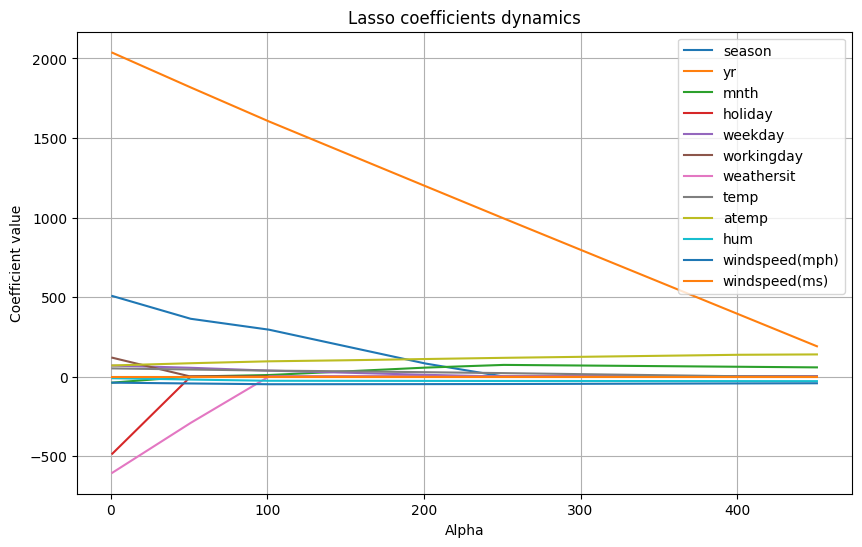

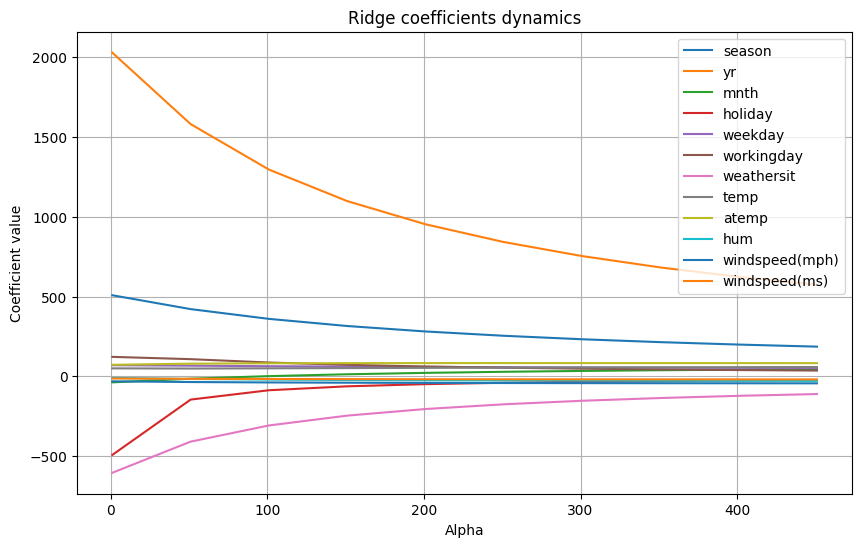

In [31]:
# Застосувала свій код
# Графіки для Lasso
plt.figure(figsize=(10, 6))
plt.title("Lasso coefficients dynamics")
plt.xlabel("Alpha")
plt.ylabel("Coefficient value")
for i in range(len(X.columns)):
    plt.plot(alphas, coefs_lasso[:, i], label=X.columns[i])
plt.legend()
plt.grid(True)
plt.show()

# Графіки для Ridge
plt.figure(figsize=(10, 6))
plt.title("Ridge coefficients dynamics")
plt.xlabel("Alpha")
plt.ylabel("Coefficient value")
for i in range(len(X.columns)):
    plt.plot(alphas, coefs_ridge[:, i], label=X.columns[i])
plt.legend()
plt.grid(True)
plt.show()

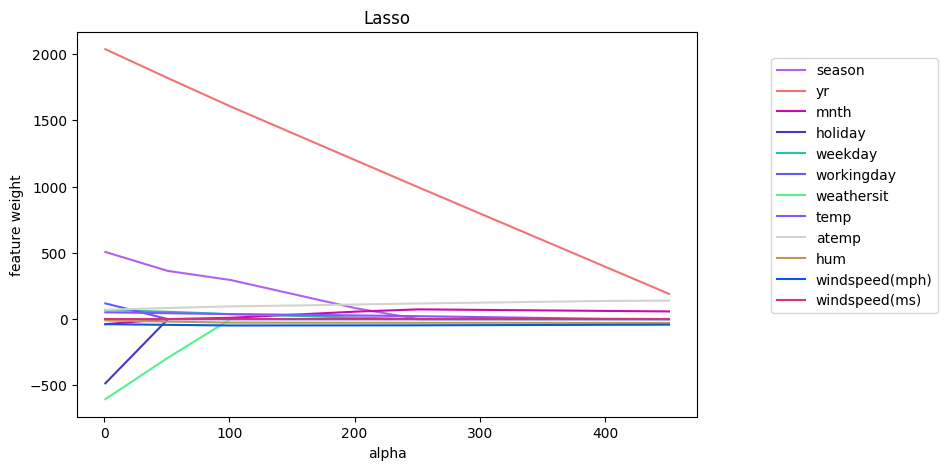

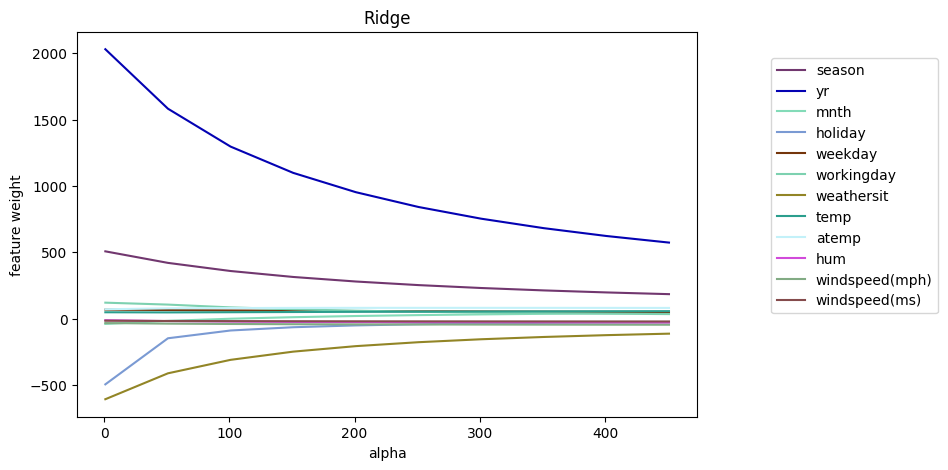

In [30]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
**Відповідь:** Lasso є агресивнішим, оскільки він здатний зменшувати ваги ознак до точно нульових значень.
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
**Відповідь:** Якщо значення параметра регуляризації (alpha) для Lasso регуляризації стане дуже великим, то більшість ваг ознак буде зменшена до нуля. Це відбувається через те, що Lasso використовує L1-норму для регуляризації, яка має тенденцію змушувати ваги ознак ставати нульовими. Чим більше значення alpha, тим сильніше цей ефект.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
**Відповідь:** Lasso може виключити одну з ознак windspeed при будь-якому значенні alpha > 0. Оскільки windspeed та windspeed(ms) є ознаками, які пов'язані між собою (одна вимірюється в милях на годину, а інша - в метрах на секунду), Lasso може вибрати одну з цих ознак для виключення, так як вони можуть мати подібний вплив на модель.
У випадку регресора Ridge, який використовує L2-норму для регуляризації, ваги ознак ніколи не стануть точно нульовими, навіть при дуже великих значеннях параметра регуляризації (alpha).
1. Який із регуляризаторів підійде для відбору неінформативних ознак?
**Відповідь:** Для відбору неінформативних ознак, тобто для відбору найбільш важливих ознак і виключення менш важливих, краще використовувати Lasso (L1 регуляризація).

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [34]:
from sklearn.linear_model import LassoCV

In [47]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()



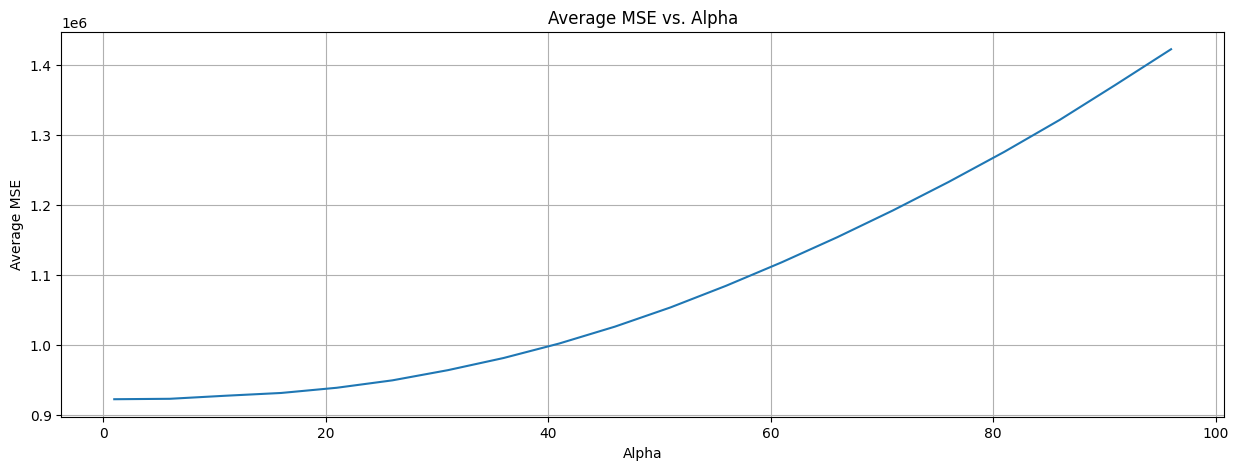

Alpha = 1
         season: 506.55
             yr: 2036.23
           mnth: -38.08
        holiday: -484.65
        weekday: 68.94
     workingday: 118.45
     weathersit: -604.57
           temp: 51.36
          atemp: 69.91
            hum: -10.35
 windspeed(mph): -38.34
  windspeed(ms): -0.0


In [79]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)
# Навчання регресора LassoCV
regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)

# Отримання середніх значень MSE
mse_mean = np.mean(regressor.mse_path_, axis=1)

# Побудова графіка
create_plot(list(zip(regressor.alphas_, mse_mean)), "Average MSE vs. Alpha", "Alpha", "Average MSE")

# Виведення вибраного alpha
print("Alpha =", regressor.alpha_)

# Виведення пар "ознака-коефіцієнт"
coefficients = dict(zip(df.columns[:-1], regressor.coef_))
for feature, coef in coefficients.items():
    print(f"{feature: >15}: {coef.round(2)}")


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [84]:
# Знаходження індексів мінімальних значень MSE на кожному розбитті
min_indices = np.argmin(regressor.mse_path_, axis=0)

print("Alphas with minimum MSE:")
for i, index in enumerate(min_indices):
    alpha = regressor.alphas_[index]
    mse = regressor.mse_path_[index, i]
    print(f"Alpha = {alpha:.2f}, MSE = {mse:.6f}")

Alphas with minimum MSE:
Alpha = 1.00, MSE = 783221.200732
Alpha = 51.00, MSE = 606705.650674
Alpha = 1.00, MSE = 1234577.177561


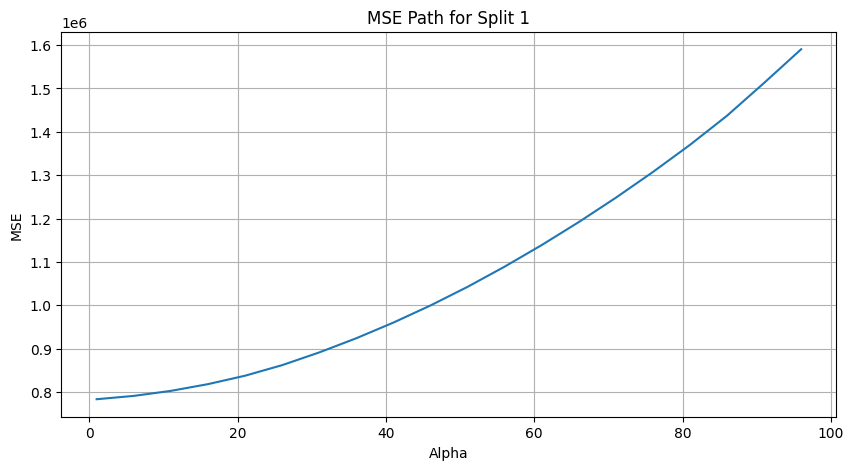

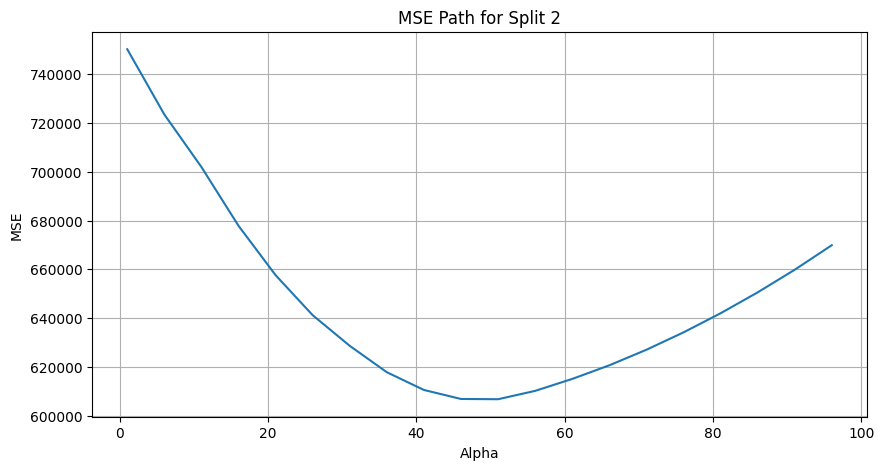

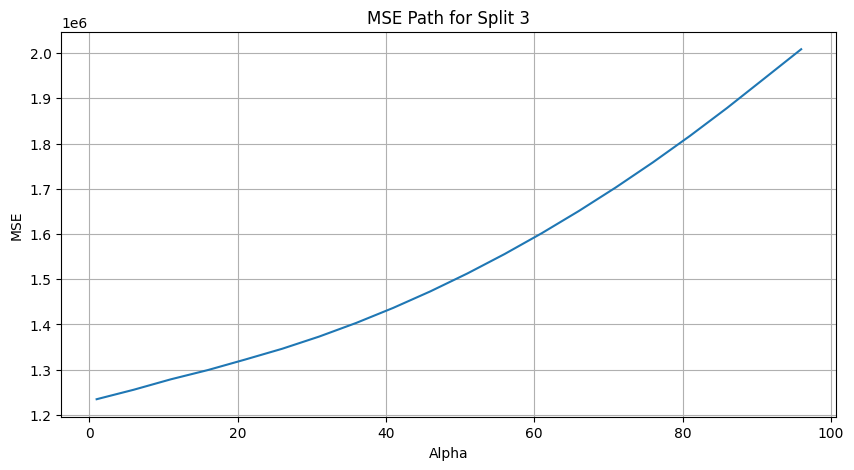

In [85]:
# Побудова трьох окремих графіків
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i])
    plt.title(f"MSE Path for Split {i+1}")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.show()


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками?

**Відповідь: **візуально видно
Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

**Відповідь:** На перший погляд, так, можна припустити, що існує певна логіка в ствердженні, що чим більше значення деяких ознак, таких як season, yr, workingday, atemp, тим більше людей захочуть взяти велосипеди.

Наприклад:

Ознака season і atemp: Люди, ймовірно, більш схильні орендувати велосипеди в теплу пору року, коли погода сприятлива для катання.
Ознака yr: Може вказувати на зростання популярності велосипедів в цілому.
Ознака workingday: Люди, ймовірно, частіше орендують велосипеди у робочі дні для пересування на роботу.

Але, варто підкрслити, що це лише припущення на основі певного аналізу даних. Для зроблення висновків про причинно-наслідкові зв'язки потрібно провести більш глибокий аналіз та можливо використовувати додаткові статистичні методи.

__Відповідь:


In [86]:
# Створення словника з ознаками та їх коефіцієнтами
feature_coefficients = dict(zip(df.columns[:-1], regressor.coef_))

# Відбір 4 ознак з найбільшими позитивними коефіцієнтами
top_features = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)[:4]
print("Top 4 features with highest positive coefficients:")
for feature, coef in top_features:
    print(f"{feature : >15}: {coef.round (2)}")


Top 4 features with highest positive coefficients:
             yr: 2036.23
         season: 506.55
     workingday: 118.45
          atemp: 69.91


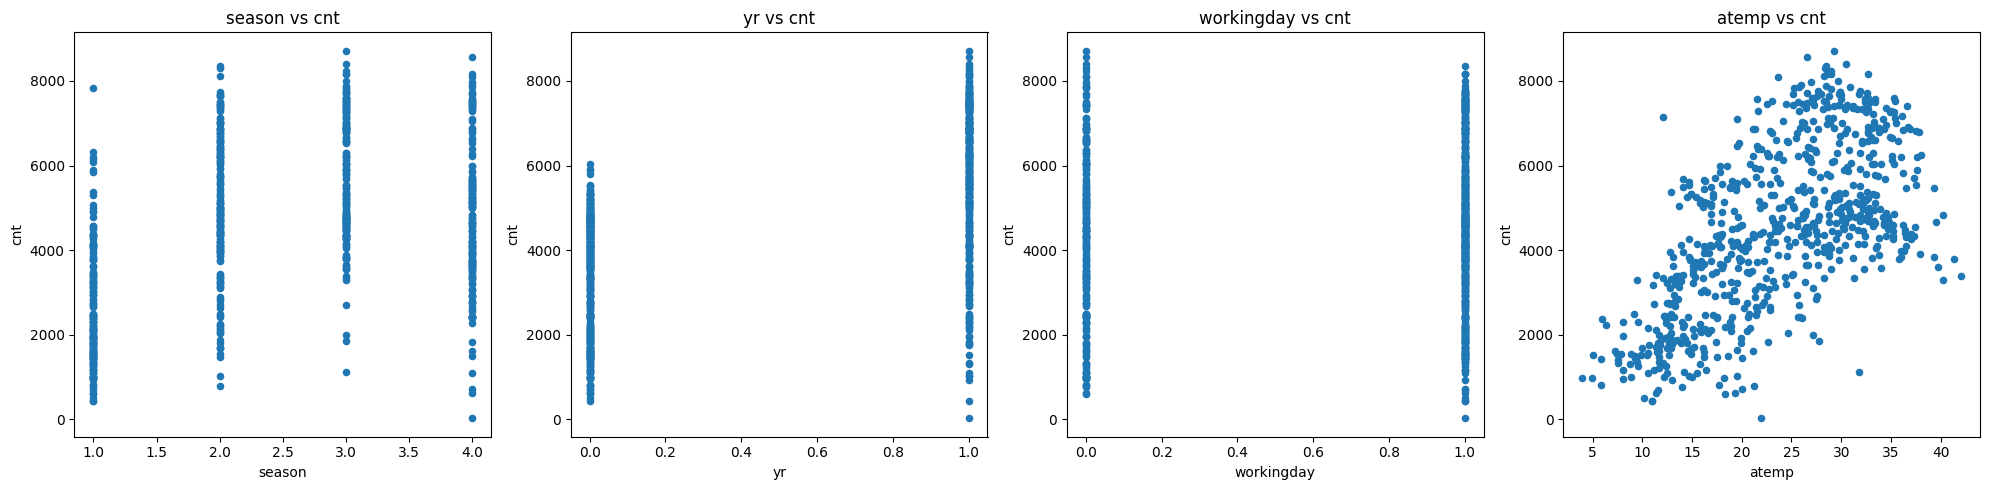

In [87]:
plt.figure(figsize=(20, 5))

# Залежність ознак від 'cnt'
features_1 = ['season', 'yr', 'workingday', 'atemp']
for i, feature in enumerate(features_1, 1):
    plt.subplot(1, 4, i)  # Змінено розміщення підграфіків
    df.plot(x=feature, y='cnt', kind='scatter', ax=plt.gca())
    plt.title(f'{feature} vs cnt')

plt.tight_layout()
plt.show()




#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації.
**Відповідь:** це такі ознаки, як  weathersit ( -604.566712), holiday (-484.651946)
 і windspeed(mph) (-38,34).

Чи видно лінійну залежність, що зменшується?
**Відповідь:** Так, помітно, особливо на перший двух графіках, де негативні значення за модулем альфа були найвищими.
Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?
**Відповідь:**Так, звичайно у свята і несприятливі дні кількість прокатів зменшується, оскільки люди використовують інші види транспорту. Але,як і в першому варіанті, довести це можна лише із допомогою додаткових статистичих методів.

__Відповідь:__

In [100]:
# Збереження негативних значень альфа та їх коефіцієнтів
negative_alphas_coefficients = {}

# Перевірка коефіцієнтів та вибір негативних альфа
for alpha, coef, feature in zip(regressor.alphas_, regressor.coef_, df.columns[:-1]):
    if coef < 0:
        negative_alphas_coefficients[alpha] = (coef, feature)

# Виведення негативних значень альфа та їх коефіцієнтів
print("Negative alphas and their coefficients:")
for alpha, (coef, feature) in negative_alphas_coefficients.items():
    print(f"Alpha = {alpha}: Coefficient for {feature} = {coef:.6f}")


Negative alphas and their coefficients:
Alpha = 86: Coefficient for mnth = -38.078270
Alpha = 81: Coefficient for holiday = -484.651946
Alpha = 66: Coefficient for weathersit = -604.566712
Alpha = 51: Coefficient for hum = -10.352705
Alpha = 46: Coefficient for windspeed(mph) = -38.341068


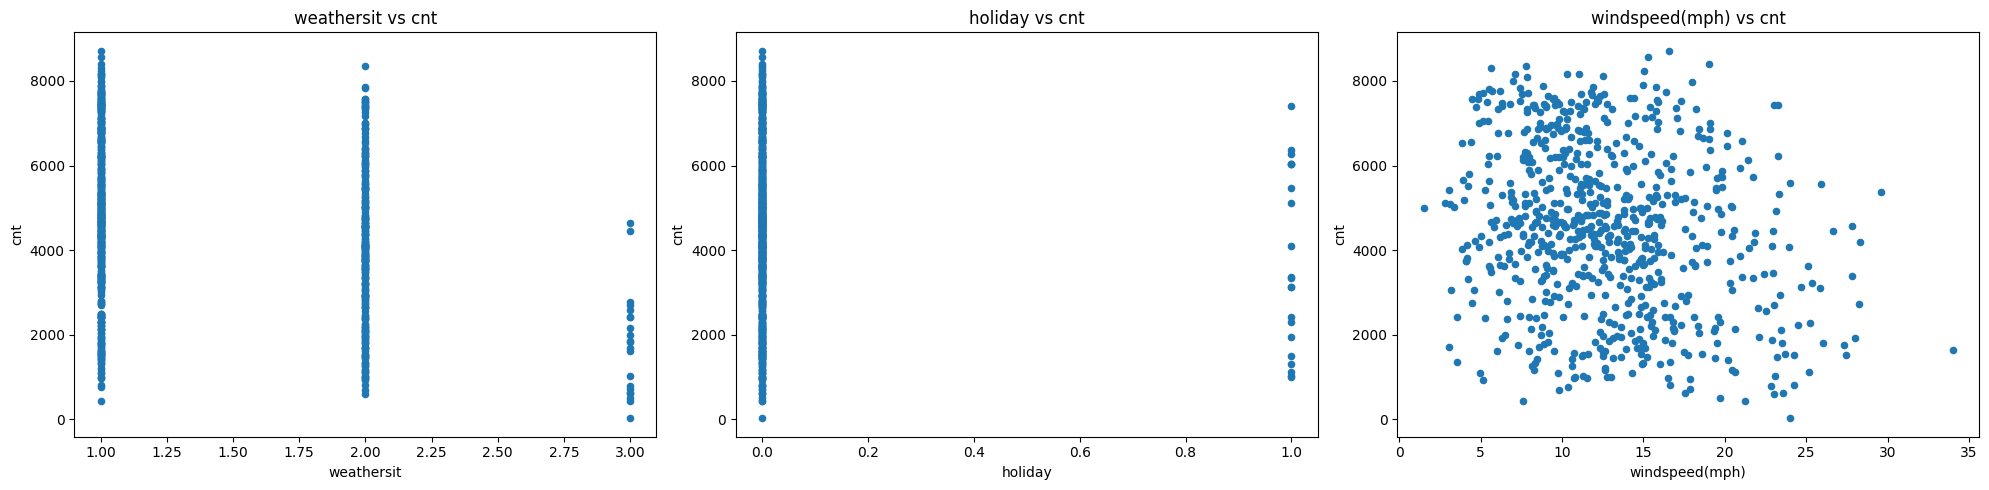

In [101]:
plt.figure(figsize=(20, 5))

# Залежність ознак від 'cnt'
features_1 = ['weathersit', 'holiday','windspeed(mph)']
for i, feature in enumerate(features_1, 1):
    plt.subplot(1, 3, i)  # Змінено розміщення підграфіків
    df.plot(x=feature, y='cnt', kind='scatter', ax=plt.gca())
    plt.title(f'{feature} vs cnt')

plt.tight_layout()
plt.show()


#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__ Такою ознакою є : windspeed(ms): -0.0. Це означає, що модель практично не враховує цю ознаку під час прогнозування попиту на велосипеди. Це може бути зумовлено кількома причинами:

Мультиколінеарність: Ознаки windspeed(ms) та windspeed(mph) можуть бути досить сильно корельовані (просто переведені одна одній за іншою формулою), тому модель вважає, що вони містять однакову інформацію.

Збіг із іншими ознаками: Інші ознаки в моделі можуть вже включати в себе інформацію про швидкість вітру, що робить windspeed(ms) зайвим.

In [ ]:
# ???

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.